In [2]:
##############################################
# Manually construct behaviors               #
##############################################

# Packages
import pickle
import numpy as np
import time
import rospy
import rospkg
from corrective_shared_autonomy.TaskModels.DMPLWRhardcoded import HybridSegment
from corrective_shared_autonomy.TaskModels.DMPLWRhardcoded import DMPLWRhardcoded
from corrective_shared_autonomy.TaskModels.FragmentedExecution import interpMultD
from core_robotics.dataviz import threedplot, highlightedthreedplot
from core_robotics.PyBSpline import BSplineSurface
from scipy.spatial.transform import Rotation as ScipyR
from scipy.spatial.transform import Slerp
import matplotlib.pyplot as plt

rospy.init_node('subdivisiontester', anonymous=True)

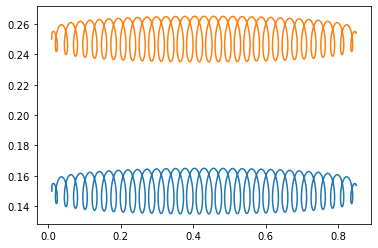

In [6]:
###################################################
# Red Overhead bin: IRC_piece1 ####################
###################################################

rospack = rospkg.RosPack()
uliconfigpath = rospack.get_path('uli_config')
config_dir = rospack.get_path('uli_config')+'/registration_models/'

outfile  = config_dir + 'IRC_piece1_2pass_frag.pkl'

ang_relative_to_surface = 0 # degree

tool_offset = np.array([-0.04, 0.0, 0.0])
state_names = ['u','v','f','theta_qx','theta_qy','theta_qz','theta_qw','delta_s','valve','tool_offset_x','tool_offset_y','tool_offset_z']
# starting = [[0.01, 0.04], [0.01, 0.09], [0.01, 0.15], [0.01, 0.25], [0.01, 0.35], [0.01, 0.45], [0.01, 0.55], [0.01, 0.65], [0.01, 0.75], [0.01, 0.85], [0.01, 0.91], [0.01, 0.96]]
# ending = [[0.85, 0.04], [0.85, 0.09], [0.85, 0.15], [0.85, 0.25], [0.85, 0.35], [0.85, 0.45], [0.85, 0.55], [0.85, 0.65], [0.85, 0.75], [0.85, 0.85], [0.85, 0.91], [0.85, 0.96]]
starting = [[0.01, 0.15], [0.01, 0.25]]
ending = [[0.85, 0.15], [0.85, 0.25]]

samps_per_sec = 40
# samps = samps_per_sec * np.array([10,10,10,10,10])
samps = samps_per_sec * np.array([80,80,80,80,80,80,80,80,80,80,80,80])
forces = np.array([-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20, -20])
angs = np.array([-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10])

state_vals = []
for ii in range(0,len(starting)):
    R_tool_surf = ScipyR.from_euler('zy',[ang_relative_to_surface,angs[ii]],degrees=True)
    theta_q = R_tool_surf.as_quat()
    start_temp = np.array([starting[ii][0],starting[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
    end_temp = np.array([ending[ii][0],ending[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
#     state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3]))
    state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.04], super_pos_amp=[0.015]))

# Plot 2D passes
for ii in range(0,len(starting)):
    plt.plot(state_vals[ii][0,:],state_vals[ii][1,:])
plt.show()
    
R_extra_tool = ScipyR.from_euler('y',-5,degrees=True)
q_extra = R_extra_tool.as_quat()
corrections = [[0.0, 0.0, -6.0, q_extra[0], q_extra[1], q_extra[2], q_extra[3], -0.5, 0.0, -0.01, 0.0, 0.0]]

pickle.dump((state_names,state_vals,corrections),open(outfile,"wb"), protocol=2)

In [11]:
def make_forward_backward_paths(num_paths=7, near_edge=0.25, far_edge=0.6, lateral_spacing=0.10):
    edge1 = near_edge
    edge2 = far_edge
    num_paths = num_paths
    lateral_spacing = lateral_spacing
    starting = []
    ending = []
    start_lat_pos = 0.17
    extra = 0.05 # extra sanding on backward path to reach&sand the center
    
    if num_paths > 7:
        print("ERROR: Span of paths likely to fall off piece")
        return
    
    # bad code style, just so this part is easy to copy+paste if needed
    if num_paths > 0:
        starting = [[edge1, start_lat_pos], [edge2, start_lat_pos]]
        ending =   [[edge2, start_lat_pos], [edge1-extra, start_lat_pos]]
        
        if num_paths == 1:
            print("Created", num_paths, "forward-backward path at lateral position:", start_lat_pos)
    

    for path_idx in range(1, num_paths):
        lat = lateral_spacing * path_idx
        starting.extend([[edge1, start_lat_pos+lat], [edge2,       start_lat_pos+lat]])
        ending.extend(  [[edge2, start_lat_pos+lat], [edge1-extra, start_lat_pos+lat]])

        if path_idx == (num_paths-1):
            print("Created", num_paths, "forward-backward paths, spanning from", start_lat_pos, "to", 
                  start_lat_pos+lat, "with lateral spacing of", lateral_spacing)

    return starting, ending

# For testing:
make_forward_backward_paths(num_paths=2)

Created 2 forward-backward paths, spanning from 0.17 to 0.27 with lateral spacing of 0.1


([[0.25, 0.17], [0.6, 0.17], [0.25, 0.27], [0.6, 0.27]],
 [[0.6, 0.17], [0.2, 0.17], [0.6, 0.27], [0.2, 0.27]])

Created path at 0.71 , from 0.33 to 0.6


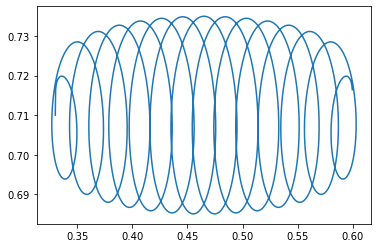

In [51]:
###################################################
# Anna Flat Piece ####################
###################################################

rospack = rospkg.RosPack()
uliconfigpath = rospack.get_path('uli_config')
config_dir = rospack.get_path('uli_config')+'/registration_models/'

outfile  = config_dir + 'anna_flat1_frag.pkl'

ang_relative_to_surface = 0 # degree

tool_offset = np.array([0.0, 0.0, 0.000])
state_names = ['u','v','f','theta_qx','theta_qy','theta_qz','theta_qw','delta_s','valve','tool_offset_x','tool_offset_y','tool_offset_z']
# delta_s: change in "speed" but more complicated (S is DMP specific term)

# length of starting and ending arrays = number of passes
# starting = [[0.01, 0.04], [0.01, 0.09], [0.01, 0.15], [0.01, 0.25], [0.01, 0.35], [0.01, 0.45], [0.01, 0.55], [0.01, 0.65], [0.01, 0.75], [0.01, 0.85], [0.01, 0.91], [0.01, 0.96]]
# ending = [[0.85, 0.04], [0.85, 0.09], [0.85, 0.15], [0.85, 0.25], [0.85, 0.35], [0.85, 0.45], [0.85, 0.55], [0.85, 0.65], [0.85, 0.75], [0.85, 0.85], [0.85, 0.91], [0.85, 0.96]]
near_edge = 0.25
far_edge = 0.6
bolt_edge = 0.33
lateral = 0.10 # min lateral dist. b/t paths should be ~0.12
num_paths = 5 # Default: 6
starting = []
ending = []
# starting, ending = make_forward_backward_paths(num_paths, near_edge=near_edge, far_edge=far_edge, lateral_spacing=lateral) # MAX num_paths 6 paths


# TODO: The complete pass had spacing of 0.13 I've now changed it back to 0.12...now .11, now .10
#    I've also changed x_ang_offset from 2.5 to 2, and now 2.25




# # Prepend shortened path to list of paths, to account for bolts fastening the piece
# starting[:0] = [[bolt_edge, 0.07], [far_edge,       0.07]]
# ending[:0] =   [[far_edge,  0.07], [near_edge-0.05, 0.07]] # -0.05 to get sander to the middle
# print("Created shortened path at beginning")

# Append shortened path to list of paths, to account for bolts fastening the piece
# lateral_end = 0.82 # default 0.92
# starting.extend([[bolt_edge, lateral_end], [far_edge,  lateral_end]])
# ending.extend(  [[far_edge,  lateral_end], [near_edge, lateral_end]])
# print("Created shortened path at the end")


# # Append a One-off test path to list of paths
# lateral_loc = 0.91
begin_loc = bolt_edge
end_loc = far_edge
# starting.extend([[begin_loc, lateral_loc]])
# ending.extend(  [[end_loc,  lateral_loc]])
# print("Created path at", lateral_loc, ", from", begin_loc, "to", end_loc)

# lateral_loc = 0.81
# #begin_loc = bolt_edge
# #end_loc = far_edge
# starting.extend([[begin_loc, lateral_loc]])
# ending.extend(  [[end_loc,  lateral_loc]])
# print("Created path at", lateral_loc, ", from", begin_loc, "to", end_loc)

lateral_loc = 0.71
# #begin_loc = bolt_edge
# #end_loc = far_edge
starting.extend([[begin_loc, lateral_loc]])
ending.extend(  [[end_loc,  lateral_loc]])
print("Created path at", lateral_loc, ", from", begin_loc, "to", end_loc)


# print(starting)
# print(ending)


# dd = 0.0
# starting = [[edge1, 0.8-dd], [edge2, 0.8-dd]] 
# ending =   [[edge2, 0.8-dd], [edge1, 0.8-dd]]
# dd = 0.12
# starting.extend([[edge1, 0.8-dd], [edge2, 0.8-dd]])
# ending.extend(  [[edge2, 0.8-dd], [edge1, 0.8-dd]])

samps_per_sec = 40 #40 is hardcoded into FragmentedExecution.py
samps = samps_per_sec * np.array([ 70, 30, 20] * 20) # default: 35, num samples affects task speed, as interpolation happens slower
forces =                np.array([-16.0, -0.05, -0.01] * 20) # default: -10
angs =                  np.array([-0., 0.] * 10) # default [-6, 6.]
x_ang_offset = 2.25 # Default: 2.25

state_vals = []
# for each path...
for ii in range(0,len(starting)):
    R_tool_surf = ScipyR.from_euler('zyx',[ang_relative_to_surface,angs[ii], x_ang_offset],degrees=True) # 'z' in 'zy' is older term referring to tool/eef directionality
    theta_q = R_tool_surf.as_quat()
    start_temp = np.array([starting[ii][0],starting[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
    end_temp = np.array([ending[ii][0],ending[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
#     state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3]))
# super_pos_freq=[0.04] and super_pos_amp=[0.015]  were in below line
    state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.02], super_pos_amp=[0.025]))
                                                            #   quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.04], super_pos_amp=[0.015]

# Plot 2D passes
for ii in range(0,len(starting)):
    plt.plot(state_vals[ii][0,:],state_vals[ii][1,:])
plt.show()
    
R_extra_tool = ScipyR.from_euler('y',-5,degrees=True)
q_extra = R_extra_tool.as_quat()

# scalar on how corrections affect the system
corrections = [[0.0, 0.0, -6.0, q_extra[0], q_extra[1], q_extra[2], q_extra[3], -0.5, 0.0, -0.01, 0.0, 0.0]]

pickle.dump((state_names,state_vals,corrections),open(outfile,"wb"), protocol=2)

Created path at 0.09 , from 0.9 to 0.01
Created path at 0.15 , from 0.1 to 0.9999
Created path at 0.28 , from 0.95 to 0.01
Created path at 0.41 , from 0.1 to 0.9999
Created path at 0.55 , from 0.95 to 0.01
Created path at 0.57 , from 0.1 to 0.9999


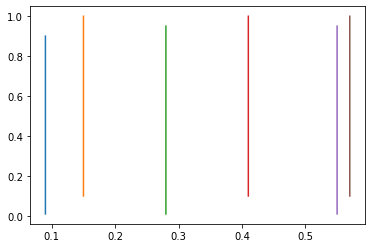

In [146]:
###################################################
# Anna Flat Piece LENGTH-WISE PATHS ####################
###################################################

rospack = rospkg.RosPack()
uliconfigpath = rospack.get_path('uli_config')
config_dir = rospack.get_path('uli_config')+'/registration_models/'

outfile  = config_dir + 'anna_flat1_frag.pkl'

ang_relative_to_surface = 0 # degree

# tool_offset = np.array([0.0, 0.0, 0.000]) I over-wrote this variable below
state_names = ['u','v','f','theta_qx','theta_qy','theta_qz','theta_qw','delta_s','valve','tool_offset_x','tool_offset_y','tool_offset_z']
# delta_s: change in "speed" but more complicated (S is DMP specific term)

# length of starting and ending arrays = number of passes
# starting = [[0.01, 0.04], [0.01, 0.09], [0.01, 0.15], [0.01, 0.25], [0.01, 0.35], [0.01, 0.45], [0.01, 0.55], [0.01, 0.65], [0.01, 0.75], [0.01, 0.85], [0.01, 0.91], [0.01, 0.96]]
# ending = [[0.85, 0.04], [0.85, 0.09], [0.85, 0.15], [0.85, 0.25], [0.85, 0.35], [0.85, 0.45], [0.85, 0.55], [0.85, 0.65], [0.85, 0.75], [0.85, 0.85], [0.85, 0.91], [0.85, 0.96]]
near_edge = 0.25
far_edge = 0.6
bolt_edge = 0.33
lateral = 0.10 # min lateral dist. b/t paths should be ~0.12
num_paths = 5 # Default: 6
starting = []
ending = []
# starting, ending = make_forward_backward_paths(num_paths, near_edge=near_edge, far_edge=far_edge, lateral_spacing=lateral) # MAX num_paths 6 paths


# TODO: The complete pass had spacing of 0.13 I've now changed it back to 0.12...now .11, now .10
#    I've also changed x_ang_offset from 2.5 to 2, and now 2.25




# # Prepend shortened path to list of paths, to account for bolts fastening the piece
# starting[:0] = [[bolt_edge, 0.07], [far_edge,       0.07]]
# ending[:0] =   [[far_edge,  0.07], [near_edge-0.05, 0.07]] # -0.05 to get sander to the middle
# print("Created shortened path at beginning")

# Append shortened path to list of paths, to account for bolts fastening the piece
# lateral_end = 0.82 # default 0.92
# starting.extend([[bolt_edge, lateral_end], [far_edge,  lateral_end]])
# ending.extend(  [[far_edge,  lateral_end], [near_edge, lateral_end]])
# print("Created shortened path at the end")


# # Append a One-off test path to list of paths
# begin_loc = 0.6
# end_loc = 0.1
# lateral_loc = 0.71
# #begin_loc = bolt_edge
# #end_loc = far_edge

length_wise_location = 0.09 # 0.25 for bottom path, 0.6 for top path
start_loc = 0.9
end_loc = 0.01
starting.extend([[length_wise_location, start_loc]])
ending.extend(  [[length_wise_location, end_loc]])
print("Created path at", length_wise_location, ", from", start_loc, "to", end_loc)

length_wise_location = 0.15 # 0.25 for bottom path, 0.6 for top path
start_loc = 0.1
end_loc = 0.9999
starting.extend([[length_wise_location, start_loc]])
ending.extend(  [[length_wise_location, end_loc]])
print("Created path at", length_wise_location, ", from", start_loc, "to", end_loc)

length_wise_location = 0.28 # 0.25 for bottom path, 0.6 for top path
start_loc = 0.95
end_loc = 0.01
starting.extend([[length_wise_location, start_loc]])
ending.extend(  [[length_wise_location, end_loc]])
print("Created path at", length_wise_location, ", from", start_loc, "to", end_loc)

length_wise_location = 0.41 # 0.25 for bottom path, 0.6 for top path
start_loc = 0.1
end_loc = 0.9999
starting.extend([[length_wise_location, start_loc]])
ending.extend(  [[length_wise_location, end_loc]])
print("Created path at", length_wise_location, ", from", start_loc, "to", end_loc)

length_wise_location = 0.55 # 0.25 for bottom path, 0.6 for top path
start_loc = 0.95
end_loc = 0.01
starting.extend([[length_wise_location, start_loc]])
ending.extend(  [[length_wise_location, end_loc]])
print("Created path at", length_wise_location, ", from", start_loc, "to", end_loc)

length_wise_location = 0.57 # 0.25 for bottom path, 0.6 for top path
start_loc = 0.1
end_loc = 0.9999
starting.extend([[length_wise_location, start_loc]])
ending.extend(  [[length_wise_location, end_loc]])
print("Created path at", length_wise_location, ", from", start_loc, "to", end_loc)


# print(starting)
# print(ending)


# dd = 0.0
# starting = [[edge1, 0.8-dd], [edge2, 0.8-dd]] 
# ending =   [[edge2, 0.8-dd], [edge1, 0.8-dd]]
# dd = 0.12
# starting.extend([[edge1, 0.8-dd], [edge2, 0.8-dd]])
# ending.extend(  [[edge2, 0.8-dd], [edge1, 0.8-dd]])

samps_per_sec = 40 #40 is hardcoded into FragmentedExecution.py
samps = samps_per_sec * np.array([90, 95, 95, 95, 95, 100]) # default: 115 for 5 passes, 95 for 6 passes
forces =                np.array([-8.0] * 20) # default: -10
angs =                  np.array([-0.25, -0.25, -0.25, -0.25, -0.25, 4] * 1) # default: [-0.25] # ROLL relative to length-wise motion
x_ang_offset =          np.array([-6, 6] * 10) # PITCH relative to length-wise motion
#x_ang_offset = -18 # Default: 2.25 or 1.5 # PITCH relative to length-wise motion
# tool_offset_start =     np.array([[ 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [ 0.0, 0.0, 0.0], [0.0]*3]) # default [0.0, 0.0, 0.0]
# tool_offset_end =       np.array([[-0.1, 0.0, 0.0], [0.1, 0.0, 0.0], [-0.1, 0.0, 0.0], [0.1, 0.0, 0.0]]) # default [0.0, 0.0, 0.0]

tool_offset_start =     np.array([[0.03,  0.00, 0.0], [0.0,  0.00, 0.0], [0.0, 0.00, 0.0], [0.0,  0.00, 0.0], [0.0, 0.00, 0.0], [0.0, 0.00, 0.0]]) # default [0.0, 0.0, 0.0]
tool_offset_end =       np.array([[0.03,  0.07, 0.0], [0.0, -0.07, 0.0], [0.0, 0.07, 0.0], [0.0, -0.07, 0.0], [0.0, 0.07, 0.0], [0.0, -0.07, 0.0]]) # default [0.0, 0.0, 0.0]


state_vals = []
# for each path...
for ii in range(0,len(starting)):
    R_tool_surf = ScipyR.from_euler('zyx',[ang_relative_to_surface, angs[ii], x_ang_offset[ii]],degrees=True) # 'z' in 'zy' is older term referring to tool/eef directionality
    theta_q = R_tool_surf.as_quat()
    start_temp = np.array([starting[ii][0],starting[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset_start[ii][0], tool_offset_start[ii][1], tool_offset_start[ii][2]])
    end_temp = np.array([ending[ii][0],ending[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset_end[ii][0], tool_offset_end[ii][1], tool_offset_end[ii][2]])
#     state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3]))
# super_pos_freq=[0.04] and super_pos_amp=[0.015]  were in below line
    state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.0], super_pos_amp=[0.0]))
                                                            #   quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.04], super_pos_amp=[0.015]

# Plot 2D passes
for ii in range(0,len(starting)):
    plt.plot(state_vals[ii][0,:],state_vals[ii][1,:])
plt.show()
    
R_extra_tool = ScipyR.from_euler('y',-5,degrees=True)
q_extra = R_extra_tool.as_quat()

# scalar on how corrections affect the system
corrections = [[0.0, 0.0, -6.0, q_extra[0], q_extra[1], q_extra[2], q_extra[3], -0.5, 0.0, -0.01, 0.0, 0.0]]

pickle.dump((state_names,state_vals,corrections),open(outfile,"wb"), protocol=2)

In [87]:
[-6, -6] + [-10] * 10
a = [[1,2], [3,6]]
print(a)
a.extend([[4,8]])
print(a)

a.insert(0,([-10, -20]))
print(a)
a[:0] = [[-30, -60]]
print(a)

a.extend([[5, 10]])
print(a)

[[1, 2], [3, 6]]
[[1, 2], [3, 6], [4, 8]]
[[-10, -20], [1, 2], [3, 6], [4, 8]]
[[-30, -60], [-10, -20], [1, 2], [3, 6], [4, 8]]
[[-30, -60], [-10, -20], [1, 2], [3, 6], [4, 8], [5, 10]]


In [26]:
np.array([1,2] * 2)

array([1, 2, 1, 2])

In [46]:
0.1 + 0.2

0.30000000000000004

In [47]:
A = 0.2
for i in range(1, 6):
    b = A * i
    print(b)

0.2
0.4
0.6000000000000001
0.8
1.0
